In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/airbnb/listings.csv")
print(df.shape)
print(df.info())
print(df.describe())

(36322, 79)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36322 entries, 0 to 36321
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            36322 non-null  int64  
 1   listing_url                                   36322 non-null  object 
 2   scrape_id                                     36322 non-null  int64  
 3   last_scraped                                  36322 non-null  object 
 4   source                                        36322 non-null  object 
 5   name                                          36320 non-null  object 
 6   description                                   35374 non-null  object 
 7   neighborhood_overview                         19084 non-null  object 
 8   picture_url                                   36322 non-null  object 
 9   host_id                                       363

In [ ]:
print(df.isnull().sum().sort_values(ascending=False).head(20))


calendar_updated               36322
license                        30993
neighborhood_overview          17238
neighbourhood                  17237
host_about                     15366
price                          14863
estimated_revenue_l365d        14863
host_response_rate             14772
host_response_time             14772
beds                           14702
bathrooms                      14640
host_acceptance_rate           14602
review_scores_location         11168
review_scores_value            11167
review_scores_checkin          11165
review_scores_accuracy         11161
review_scores_communication    11157
review_scores_cleanliness      11152
last_review                    11151
review_scores_rating           11151
dtype: int64


In [ ]:
# 1) Drop rows where price is missing
df = df.dropna(subset=['price']).copy()

In [ ]:
# 2) Convert `price` to numeric (handles "$1,234.00", commas, spaces, etc.)
df['price'] = (
    df['price']
      .astype(str)
      .str.replace(r'[^0-9\.]', '', regex=True)   # keep digits and dot only
      .replace({'': pd.NA, '.': pd.NA})
      .astype(float)
)

In [ ]:
# 3) Drop any rows where price failed to convert
df = df.dropna(subset=['price'])

In [ ]:
to_drop = [
    'calendar_updated',
    'license',
    'host_about',
    'neighborhood_overview',
    'estimated_revenue_l365d'
]
df = df.drop(columns=[c for c in to_drop if c in df.columns])

In [ ]:
# 5) Drop exact duplicate rows if any
dups = df.duplicated().sum()
if dups > 0:
    df = df.drop_duplicates()

print("Duplicates removed:", dups)
print("Shape AFTER:", df.shape)

Duplicates removed: 0
Shape AFTER: (21459, 74)


In [ ]:
# 6) Re-check top missing columns and confirm price looks good
print("\nTop missing columns after cleanup:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

print("\nPrice summary:")
print(df['price'].describe())


Top missing columns after cleanup:
neighbourhood                  10230
review_scores_location          6333
last_review                     6333
first_review                    6333
review_scores_cleanliness       6333
review_scores_checkin           6333
review_scores_accuracy          6333
review_scores_rating            6333
review_scores_value             6333
reviews_per_month               6333
review_scores_communication     6333
host_location                   4866
host_neighbourhood              4264
host_acceptance_rate            3402
host_response_rate              3227
host_response_time              3227
host_is_superhost                394
description                      372
has_availability                 242
bedrooms                          82
dtype: int64

Price summary:
count    21459.000000
mean       521.528356
std       3501.384801
min          8.000000
25%         89.000000
50%        154.000000
75%        270.000000
max      50184.000000
Name: price, dtype:

In [ ]:
# 1) Remove listings with unrealistic prices
df = df[(df['price'] >= 10) & (df['price'] <= 1000)]

In [ ]:
# 2) Remove listings with extremely high minimum nights (likely errors)
if 'minimum_nights' in df.columns:
    df = df[df['minimum_nights'] <= 365]

print("Shape AFTER outlier removal:", df.shape)

Shape AFTER outlier removal: (20945, 74)


In [ ]:
# 3) Select relevant columns for pricing analysis
keep_cols = [
    'id', 'name', 'neighbourhood', 'room_type', 'property_type',
    'price', 'minimum_nights', 'availability_365',
    'number_of_reviews', 'review_scores_rating', 'bedrooms'
]

df = df[[c for c in keep_cols if c in df.columns]].copy()

print("Columns now in use:", df.columns.tolist())

Columns now in use: ['id', 'name', 'neighbourhood', 'room_type', 'property_type', 'price', 'minimum_nights', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'bedrooms']


In [ ]:
# 4) Check remaining missing values
print("\nMissing values after column selection:")
print(df.isnull().sum())


Missing values after column selection:
id                          0
name                        0
neighbourhood           10059
room_type                   0
property_type               0
price                       0
minimum_nights              0
availability_365            0
number_of_reviews           0
review_scores_rating     6012
bedrooms                   80
dtype: int64


In [ ]:
# 1) Handle neighbourhood: fill missing with "Unknown"
if 'neighbourhood' in df.columns:
    df['neighbourhood'] = df['neighbourhood'].fillna('Unknown')

In [ ]:
# 2) Handle review_scores_rating: fill with median score
if 'review_scores_rating' in df.columns:
    median_rating = df['review_scores_rating'].median()
    df['review_scores_rating'] = df['review_scores_rating'].fillna(median_rating)

In [ ]:
# 3) Handle bedrooms: fill with median number of bedrooms
if 'bedrooms' in df.columns:
    median_bedrooms = df['bedrooms'].median()
    df['bedrooms'] = df['bedrooms'].fillna(median_bedrooms)

In [ ]:
# 4) Confirm missing values are handled
print("Remaining missing values:")
print(df.isnull().sum())

Remaining missing values:
id                      0
name                    0
neighbourhood           0
room_type               0
property_type           0
price                   0
minimum_nights          0
availability_365        0
number_of_reviews       0
review_scores_rating    0
bedrooms                0
dtype: int64


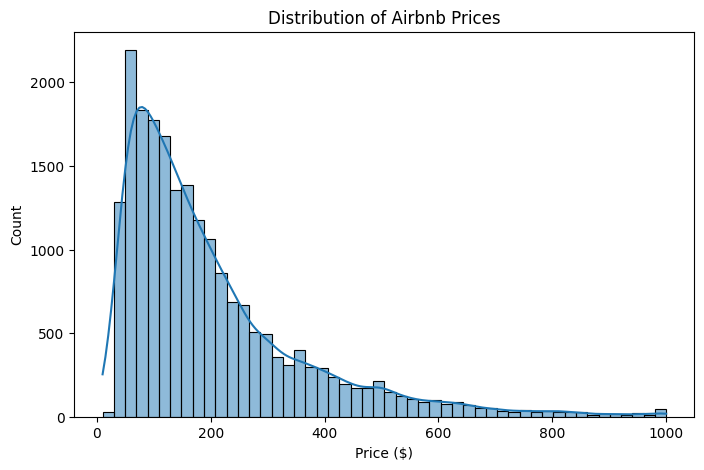

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Price distribution
plt.figure(figsize=(8,5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribution of Airbnb Prices")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.show()

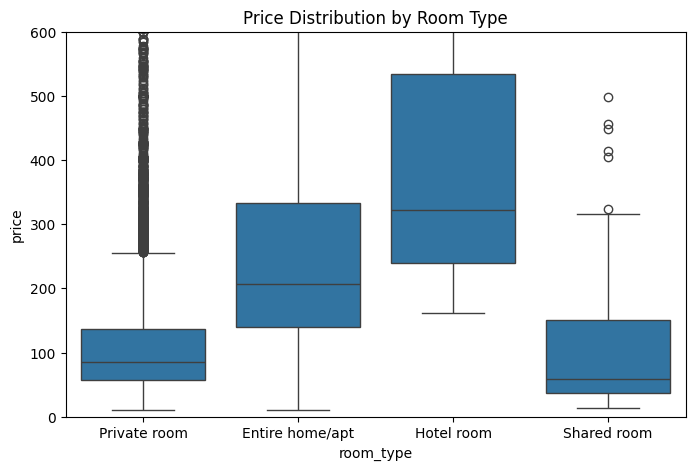

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='room_type', y='price', data=df)
plt.title("Price Distribution by Room Type")
plt.ylim(0, 600)   # cap y-axis for visibility
plt.show()

/tmp/ipython-input-1427703721.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neigh.values, y=top_neigh.index, palette="viridis")


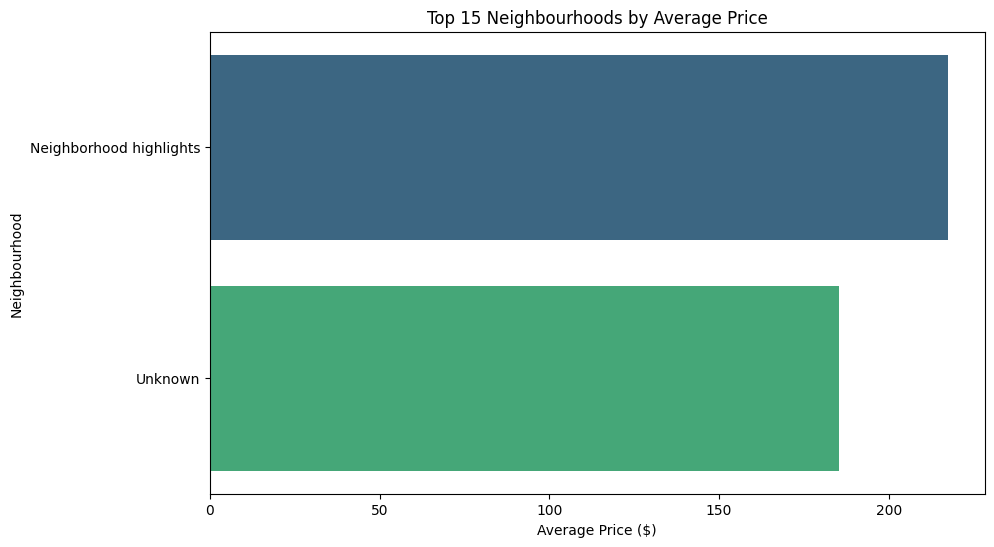

In [ ]:
plt.figure(figsize=(10,6))
top_neigh = df.groupby('neighbourhood')['price'].mean().sort_values(ascending=False).head(15)
sns.barplot(x=top_neigh.values, y=top_neigh.index, palette="viridis")
plt.title("Top 15 Neighbourhoods by Average Price")
plt.xlabel("Average Price ($)")
plt.ylabel("Neighbourhood")
plt.show()

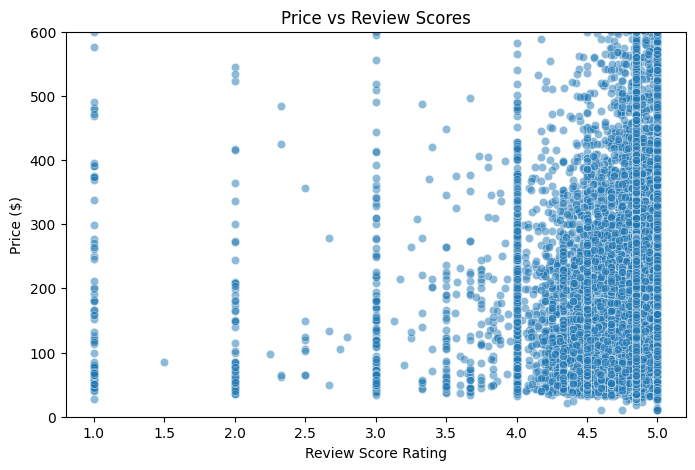

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='review_scores_rating', y='price', data=df, alpha=0.5)
plt.title("Price vs Review Scores")
plt.xlabel("Review Score Rating")
plt.ylabel("Price ($)")
plt.ylim(0, 600)   # limit to improve visibility
plt.show()

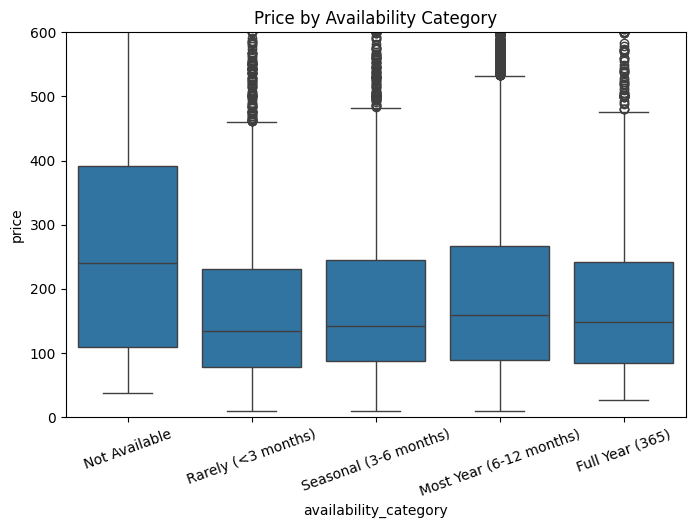

In [ ]:
# --- Availability vs Price (cleaned categories) ---

# Create bins for availability
def categorize_availability(x):
    if x == 0:
        return "Not Available"
    elif x < 90:
        return "Rarely (<3 months)"
    elif x < 180:
        return "Seasonal (3-6 months)"
    elif x < 365:
        return "Most Year (6-12 months)"
    else:
        return "Full Year (365)"

df['availability_category'] = df['availability_365'].apply(categorize_availability)

# Plot price by availability category
plt.figure(figsize=(8,5))
sns.boxplot(
    x='availability_category',
    y='price',
    data=df,
    order=[
        "Not Available",
        "Rarely (<3 months)",
        "Seasonal (3-6 months)",
        "Most Year (6-12 months)",
        "Full Year (365)"
    ]
)
plt.title("Price by Availability Category")
plt.ylim(0, 600)
plt.xticks(rotation=20)
plt.show()


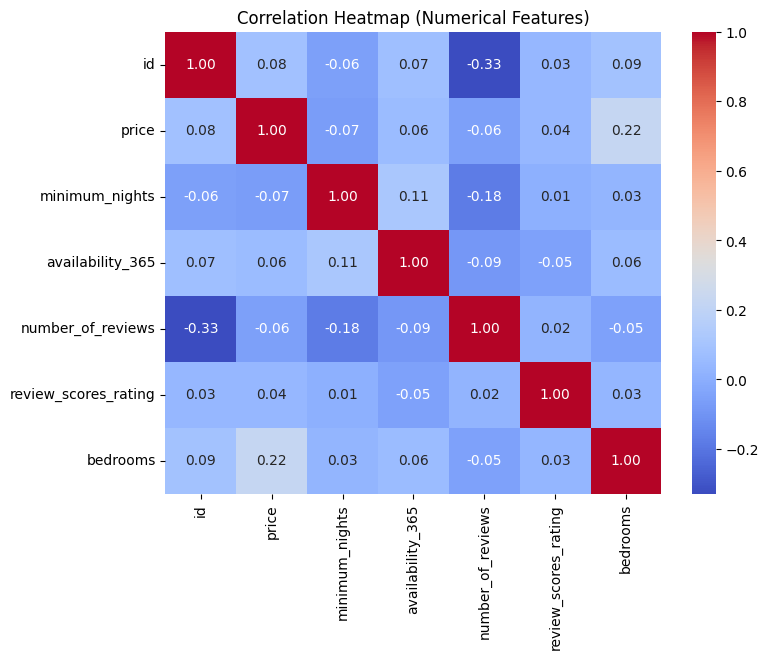

In [ ]:
# --- Correlation Heatmap for numerical features ---

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64','float64'])

# Compute correlation
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


In [ ]:
# --- Feature Engineering ---

# Select features for modeling
features = ["neighbourhood", "room_type", "property_type",
            "minimum_nights", "availability_365",
            "number_of_reviews", "review_scores_rating", "bedrooms"]

X = df[features]
y = df["price"]

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

print("Shape after encoding:", X.shape)
print("Sample columns:", X.columns[:10])

Shape after encoding: (20945, 68)
Sample columns: Index(['minimum_nights', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'bedrooms', 'neighbourhood_Unknown',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'property_type_Boat'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance:")
print("RMSE:", rmse)
print("R²:", r2)

Linear Regression Performance:
RMSE: 134.41385767421215
R²: 0.3142960497774989


In [ ]:
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression:")
print("RMSE:", rmse_ridge)
print("R²:", r2_ridge)

# Lasso Regression
lasso = Lasso(alpha=0.001, max_iter=10000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print("\nLasso Regression:")
print("RMSE:", rmse_lasso)
print("R²:", r2_lasso)

Ridge Regression:
RMSE: 134.38559218450283
R²: 0.3145844087371762

Lasso Regression:
RMSE: 134.41070775840834
R²: 0.3143281876007673


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression:")
print("RMSE:", rmse_rf)
print("R²:", r2_rf)

Random Forest Regression:
RMSE: 115.4486852641273
R²: 0.49414442187640917


/tmp/ipython-input-4166105334.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_imp, palette="viridis")


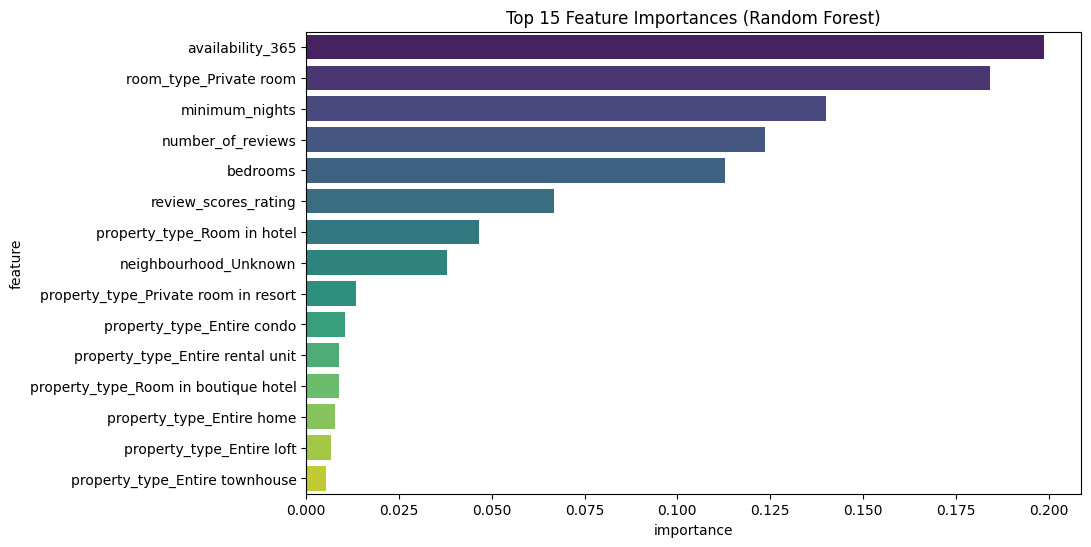

In [ ]:
# --- Feature Importance from Random Forest ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Sort importances
feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False).head(15)  # top 15

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_imp, palette="viridis")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()

In [ ]:
def recommend_price(model, user_input, df_encoded):
    """
    Predicts optimal Airbnb price based on user inputs.

    model: trained regression model (RandomForestRegressor)
    user_input: dict of feature values (e.g., {"bedrooms": 2, "room_type": "Private room"})
    df_encoded: training DataFrame (used for reference to create dummy vars)
    """
    import pandas as pd

    # Convert input to DataFrame
    input_df = pd.DataFrame([user_input])

    # One-hot encode to match training features
    input_encoded = pd.get_dummies(input_df)
    input_encoded = input_encoded.reindex(columns=df_encoded.columns, fill_value=0)

    # Predict price
    predicted_price = model.predict(input_encoded)[0]

    return round(predicted_price, 2)


# 🔹 Example usage
user_input = {
    "minimum_nights": 3,
    "availability_365": 200,
    "number_of_reviews": 50,
    "review_scores_rating": 4.5,
    "bedrooms": 2,
    "neighbourhood": "Manhattan",
    "room_type": "Private room",
    "property_type": "Apartment"
}

suggested_price = recommend_price(rf, user_input, X_train)  # rf is your trained Random Forest
print("💡 Suggested Price:", suggested_price)

💡 Suggested Price: 170.84


In [ ]:
# Add predicted prices to dataset
df["predicted_price"] = rf.predict(X)

# Save to CSV for Tableau
df.to_csv("airbnb_with_predictions.csv", index=False)

print("✅ File saved: airbnb_with_predictions.csv")

✅ File saved: airbnb_with_predictions.csv


In [ ]:
from google.colab import files
files.download('airbnb_with_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>